In [1]:
import os
import sys
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
from torch.nn import Module
from torch.optim import Adam
from torch.nn import MSELoss
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms, utils
from scipy import stats
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

np.random.seed(5001)

In [2]:
class MyDataset(Dataset):
    
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)
  
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]
        

In [3]:
image_height = {5: 32, 20: 64, 60: 96}  
image_width = {5: 15, 20: 60, 60: 180}
train_year = np.arange(1993,2001,1)
images = []
label_df = []

for year in train_year:
    images.append(np.memmap(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, image_height[20], image_width[20])))
    label_df.append(pd.read_feather(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
images = np.concatenate(images)
label_df = pd.concat(label_df)

y = label_df['Retx_20d_label'].to_numpy()
tmp = (np.isnan(y) | (y==2))
y = y[tmp==False]
images = images[tmp==False]
label_df = label_df[tmp==False]

test_year = np.arange(2001,2020,1)
test_images = []
test_label_df = []

for year in test_year:
    test_images.append(np.memmap(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, image_height[20], image_width[20])))
    test_label_df.append(pd.read_feather(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
test_images = np.concatenate(test_images)
test_label_df = pd.concat(test_label_df)

y = test_label_df['Retx_20d_label'].to_numpy()
tmp = (np.isnan(y) | (y==2))
y = y[tmp==False]
test_images = test_images[tmp==False]
test_label_df = test_label_df[tmp==False]

print(images.shape)
print(label_df.shape)
print(test_images.shape)
print(test_label_df.shape)

(787028, 64, 60)
(787028, 35)
(1394753, 64, 60)
(1394753, 35)


In [4]:
label = label_df["Retx_20d_label"]
label_value = label_df["Retx_20d"]
label = np.array(label)
label_value = np.array(label_value)


test_label = test_label_df["Retx_20d_label"]
test_label_value = test_label_df["Retx_20d"]
test_label = np.array(test_label)
test_label_value = np.array(test_label_value)

In [5]:
dataset = MyDataset(images, label)
train_val_ratio = 0.7
train_dataset, val_dataset = random_split(dataset, 
                                          [int(dataset.len*train_val_ratio), 
                                           dataset.len-int(dataset.len*train_val_ratio)], 
                                          generator=torch.Generator().manual_seed(5001))

test_dataset = MyDataset(test_images, test_label)
train_dataset_value, val_dataset_value = random_split(label_value, 
                                                      [int(dataset.len*train_val_ratio), 
                                                       dataset.len-int(dataset.len*train_val_ratio)], 
                                                      generator=torch.Generator().manual_seed(5001))

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(76800, 2),
        )
        self.softmax = nn.Softmax(dim=1)
       
    def forward(self, x):
        x = x.reshape(-1,1,64,60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(-1,76800)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

In [7]:
def train(data, model, opti, loss, device):
    model.train()
    num = 0.
    pred = []
    with tqdm(data) as t:
        for batch, (X, y) in enumerate(t):
            opti.zero_grad()
            prediction = model(X.to(device))
            loss_batch = loss(prediction, y.long().to(device))
            loss_batch.backward()
            opti.step()
            num += loss_batch.item()
            pred += prediction.cpu().tolist()
    pred_value = np.array(pred)[:,1]
    pred = torch.max(torch.Tensor(pred), 1)[1]
        
    return num / len(data), pred, pred_value

In [8]:
def evaluate(data, model, loss, device):
    model.eval()
    num = 0.
    pred = []
    
    with torch.no_grad():
        with tqdm(data) as t:
            for batch, (X, y) in enumerate(t):
                prediction = model(X.to(device))
                loss_batch = loss(prediction, y.long().to(device))
                num += loss_batch.item()
                pred += prediction.cpu().tolist()
    pred_value = np.array(pred)[:,1]
    pred = torch.max(torch.Tensor(pred), 1)[1]
        
    return num / len(data), pred, pred_value

In [9]:
def trainer(trainData, valData, model, opti, loss, epoch, early_stopping_epoch, model_name, verbose, device):
    
    train_loss = []
    val_loss = []
    best_results = np.inf
    last_min_index = -1
    
    for i in range(epoch):
        start = time.time()
        train_results, train_pred, train_value = train(trainData,model,opti,loss,device)
        val_results, val_pred, val_value = evaluate(valData,model,loss,device)
        
        if (verbose):
            print("Epoch {} | Train Loss: {:.3f} - Val Loss: {:.3f} - in {:.3f} mins.".format(i+1, train_results, val_results, (time.time()-start)/60))
            
        if val_results < best_results:
            torch.save(model.state_dict(), model_name+'.pth.tar')
            best_results = val_results
            best_train_pred = train_pred
            best_val_pred = val_pred
            best_train_value = train_value
            best_val_value = val_value
            last_min_index = i
        elif i - last_min_index >= early_stopping_epoch:
            break
        
        train_loss.append(train_results)
        val_loss.append(val_results)
        
    torch.save({'train_losses': train_loss,
                'val_losses': val_loss,
                'min_val_loss': min(val_loss)
               },model_name+'_loss.pth.tar')
    
    return torch.load(model_name+'_loss.pth.tar'), best_train_pred, best_val_pred, best_train_value, best_val_value  

In [10]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

In [11]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
def plot_roc(labels, predict_prob):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.figure()
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

## BEST Validation results

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

bs = 256
lr = 1e-5
epoch = 20
early_stopping_epoch = 2

trainData = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, pin_memory=True)
valData = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False, pin_memory=True)

model = CNN().to(device)
model.apply(init_weights)
# model = CNN().to(device)
# model.load_state_dict(torch.load("CNN_baseline.pth.tar"))

opti = Adam(model.parameters(),lr=lr)
loss = nn.CrossEntropyLoss()

out_results, train_pred, val_pred, train_value, val_value = trainer(trainData, valData, model, opti, loss, epoch, early_stopping_epoch, 'CNN_2layer', True, device)
# print("Batch Size: {} | Learning Rate: {} - Min. Val. Loss: {} ".format(bs, 
#                                                                         lr, 
#                                                                         out_results['min_val_loss']
#                                                                         ))
# accuracy = (val_pred == val_dataset[:][1]).sum().item() / len(val_dataset)
# print("Val Accuracy: ", accuracy)
# print("Correlation Spearman: ", stats.spearmanr(list(val_value),list(val_dataset_value)))
# print("Correlation Pearson: ", stats.pearsonr(list(val_value),list(val_dataset_value)))
# plot_roc(np.array(val_dataset_value), np.array(val_value))

  0%|                                                                                 | 1/2153 [00:00<04:08,  8.66it/s]

Epoch 1 | Train Loss: 0.735 - Val Loss: 0.707 - in 4.888 mins.


  0%|                                                                                 | 1/2153 [00:00<03:54,  9.17it/s]

Epoch 2 | Train Loss: 0.725 - Val Loss: 0.697 - in 3.868 mins.


  0%|                                                                                 | 1/2153 [00:00<03:54,  9.17it/s]

Epoch 3 | Train Loss: 0.720 - Val Loss: 0.699 - in 3.864 mins.


  0%|                                                                                 | 1/2153 [00:00<03:56,  9.10it/s]

Epoch 4 | Train Loss: 0.714 - Val Loss: 0.697 - in 3.872 mins.


  0%|                                                                                 | 1/2153 [00:00<03:55,  9.12it/s]

Epoch 5 | Train Loss: 0.710 - Val Loss: 0.699 - in 3.865 mins.


  0%|                                                                                 | 1/2153 [00:00<03:58,  9.01it/s]

Epoch 6 | Train Loss: 0.707 - Val Loss: 0.694 - in 3.861 mins.


  0%|                                                                                 | 1/2153 [00:00<04:17,  8.35it/s]

Epoch 7 | Train Loss: 0.704 - Val Loss: 0.692 - in 3.866 mins.


  0%|                                                                                 | 1/2153 [00:00<04:03,  8.85it/s]

Epoch 8 | Train Loss: 0.701 - Val Loss: 0.690 - in 3.862 mins.


  0%|                                                                                 | 1/2153 [00:00<04:09,  8.64it/s]

Epoch 9 | Train Loss: 0.699 - Val Loss: 0.691 - in 3.867 mins.


100%|████████████████████████████████████████████████████████████████████████████████| 923/923 [00:29<00:00, 31.68it/s]

Epoch 10 | Train Loss: 0.697 - Val Loss: 0.703 - in 3.862 mins.


Batch Size: 256 | Learning Rate: 1e-05 - Min. Val. Loss: 0.690440959558456 
Val Accuracy:  0.5409747193033726
Correlation Spearman:  SpearmanrResult(correlation=0.10795168959328819, pvalue=0.0)
Correlation Pearson:  (0.08564976139356001, 0.0)


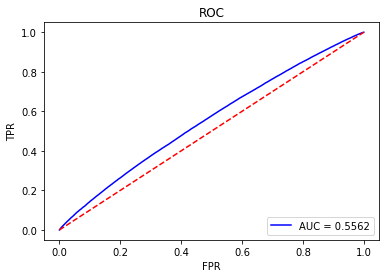

In [13]:
val_label = list()
for i in range(len(val_dataset)):
    val_label.append(val_dataset[i][1])
val_label = np.array(val_label)

print("Batch Size: {} | Learning Rate: {} - Min. Val. Loss: {} ".format(bs,lr,out_results['min_val_loss']))

accuracy = (np.array(val_pred) == val_label).sum().item() / len(val_dataset)
print("Val Accuracy: ", accuracy)
print("Correlation Spearman: ", stats.spearmanr(list(val_value),list(val_dataset_value)))
print("Correlation Pearson: ", stats.pearsonr(list(val_value),list(val_dataset_value)))
plot_roc(np.array(val_label), np.array(val_value))

## Test

100%|██████████████████████████████████████████████████████████████████████████████| 5449/5449 [03:54<00:00, 23.21it/s]


Test Loss:  0.6983879443526727
Test Accuracy:  0.5205939689679822
Correlation Spearman:  SpearmanrResult(correlation=0.05734111501804866, pvalue=0.0)
Correlation Pearson:  (0.0373271057281004, 0.0)


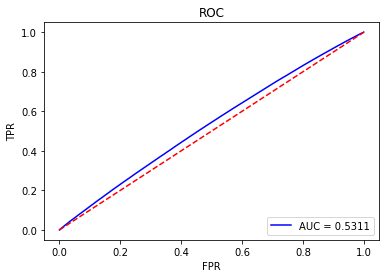

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
loss = nn.CrossEntropyLoss()

model = CNN().to(device)
model.load_state_dict(torch.load("CNN_2layer.pth.tar"))

valData = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False, pin_memory=True)
val_results, val_pred, val_value = evaluate(valData, model, loss, device)

print("Test Loss: ", val_results)
accuracy = (val_pred == test_dataset[:][1]).sum().item() / len(test_dataset)
print("Test Accuracy: ", accuracy)
print("Correlation Spearman: ", stats.spearmanr(list(val_value), list(test_label_df['Retx_20d'])))
print("Correlation Pearson: ", stats.pearsonr(list(val_value), list(test_label_df['Retx_20d'])))
# print("AUC,")
plot_roc(np.array(test_label_df['Retx_20d_label']), np.array(val_value))
#存下来val_value用来

In [15]:
CNN_out = torch.load('CNN_2layer_loss.pth.tar')

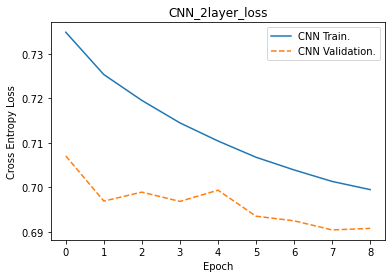

In [16]:
plt.title('CNN_2layer_loss')
plt.plot(CNN_out['train_losses'], label='CNN Train.')
plt.plot(CNN_out['val_losses'], label='CNN Validation.', linestyle='--')
_ = plt.ylabel('Cross Entropy Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend()
plt.savefig('CNN.png', bbox_inches='tight', dpi=200)